# Number Plate - OCR 

## “Improving Tesseract Performance by Retraining on provided datasets”

To enable automatic detection of number plate, a neural network is trained by us which locates the license plate in a given image, captured by the camera.

This cropped image is passed on to tesseract to predict the characters in the cropped image. The provided data set is after cropping is performed.

The tesseract is suffering with accuracy problem i.e. wrong detection of characters, missing some characters, multiple prediction of same characters which all contribute towards inaccuracy.

Objective of this exercise is to find feasibility of retraining the tesseract and how it can be achieved. Additionally, we should be able to retrain the tesseract in such a way the accuracy increases post training.


# Step 1

1. Split the provided datasets into train / test datasets
2. Run tesseract on the provided cropped license plate images and establish base line performance of tesseract without any re-training or fine-tuning on the test datasets
    a. Choose any of the parameter settings for the various –oem, --psm, language
    b. Choose and document your pre-processing steps any to establish the base-line performance (Not Critical)
    
    
### Ground Truth
Ground truth for all the images is prepared manually('groundtruth.csv').
This is then compared with the results pre- and post- training tesseract4


### Data Preparation
1. Prepare the data-files from the provided datasets for training tesseract
    a. Prepare a moderate size of train data that can demonstrate the re-train / fine-tune efficacy

**Train-vs-Test split ration => 80 : 20**

data files created for each image(say img_file.png)
* img_file.gt.txt : contains the truth value for that specific image in text format
* img_file.tif : Image is stored in TIFF format(.tif)

* Save the files in data/ground-truth and data/test


### Parameters Choosen:
* -oem = '1' for LSTM models
* -psm = '6' Assume a single uniform block of text
* lang = 'eng'



In [121]:
# Load Dependencies
import os 
import numpy as np
from PIL import Image
import pandas as pd
import pytesseract
import glob

from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import numpy as np

import cv2
import imutils

from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches

mainDir = os.getcwd()

In [13]:
fileList = glob.glob(os.path.join(mainDir + '/labelled_data/') +"/*.txt")

In [57]:
dd = pd.DataFrame(columns=['filename', 'truthValue'])
for filepath in fileList:
    imgName = filepath.split('/')[-1]
    imgName = imgName.split('.')[0] + '.png'
    with open(filepath, 'rt') as f:
        imgText = f.readlines()
    dd = dd.append({'filename': imgName, 'truthValue': imgText[0].rstrip()}, ignore_index=True)

dd.sort_values(["filename"], axis=0, ascending=True, inplace=True)
dd.index = range(len(dd))
dd.to_csv('groundtruth.csv', index_label=None, index=False)

### Image Preprocessing - helper functions

In [81]:
# Read Ground Truth
data = pd.read_csv('groundtruth.csv')

def detectPlate_replace(filename):
    '''
    Summary:
        1. Read image from the file path given
        2. Identify potential number plate
            a. convert image to gray scale
            b. apply threshold_otsu
            c. binarize the image
            d. measure the label
            e. Create a possible number plate dimension
            f. Identify region props on the image to identify potential regions that describe a number plate
            g. crop and save the image with sharp/exact number plate, 
               ignore if number plate region is not properly identified       
    input: 
        file path
    output: 
        save number-plate detected image(if found) and return the image
    '''
    # filename = os.path.join(mainDir+'/License_Plates_Crop/', filename_path)
    car_image = imread(filename, as_gray=True)
    gray_car_image = car_image * 255
    threshold_value = threshold_otsu(gray_car_image)
    binary_car_image = gray_car_image > threshold_value

    label_image = measure.label(binary_car_image)

    plate_dimensions = (0.03*label_image.shape[0], 0.08*label_image.shape[0], 0.15*label_image.shape[1], 0.3*label_image.shape[1])
    plate_dimensions2 = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])

    plate_dimensions3 = (0.20*label_image.shape[0], 0.85*label_image.shape[0], 0.15*label_image.shape[1], 0.9*label_image.shape[1])
    # plate_dimensions3 = (0.25*label_image.shape[0], 0.75*label_image.shape[0], 0.20*label_image.shape[1], 0.8*label_image.shape[1])
    min_height, max_height, min_width, max_width = plate_dimensions
    plate_objects_cordinates = []
    plate_like_objects = []

    flag =0

    for region in regionprops(label_image):
        # print(region)
        if region.area < 50:
            #if the region is so small then it's likely not a license plate
            continue
            # the bounding box coordinates
        min_row, min_col, max_row, max_col = region.bbox

        region_height = max_row - min_row
        region_width = max_col - min_col

        # ensuring that the region identified satisfies the condition of a typical license plate
        if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
            flag = 1
            plate_like_objects.append(binary_car_image[min_row:max_row,
                                      min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col,
                                             max_row, max_col))
            rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                           linewidth=2, fill=False)        

    if(flag==0):
        min_height, max_height, min_width, max_width = plate_dimensions3
        plate_objects_cordinates = []
        plate_like_objects = []

        # regionprops creates a list of properties of all the labelled regions
        for region in regionprops(label_image):
            if region.area < 50:
                #if the region is so small then it's likely not a license plate
                continue
                # the bounding box coordinates
            min_row, min_col, max_row, max_col = region.bbox

            region_height = max_row - min_row
            region_width = max_col - min_col

            # ensuring that the region identified satisfies the condition of a typical license plate
            if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
                # print("hello")
                plate_like_objects.append(binary_car_image[min_row:max_row,
                                          min_col:max_col])
                plate_objects_cordinates.append((min_row, min_col,
                                                 max_row, max_col))
                rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                               linewidth=2, fill=False)

    if plate_like_objects!=[]:
        car_image = car_image[plate_objects_cordinates[0][0]:plate_objects_cordinates[0][2],plate_objects_cordinates[0][1]:plate_objects_cordinates[0][3]]
        imsave(filename, car_image)
    return car_image

In [117]:
## Preparing .tif and .gt.txt files
# Splitting the dataset into 80% training and 20% test dataset

import random
testIndx = random.sample(list(dd.index), int(0.20*len(dd)))
targetpath = os.path.join(mainDir, 'data/ground-truth')
testpath = os.path.join(mainDir, 'data/test')

for idx in dd.index:
    if idx in testIndx:
        # Saving files to test folder
        filename = os.path.join(mainDir+'/License_Plates_Crop/', dd['filename'][idx])
        newFile = os.path.join(testpath, dd['filename'][idx].split('.')[0]+ '.tif') 
        # img = Image.open(filename)
        img = detectPlate_replace(filename)
        img = Image.open(filename)
        img.save(newFile)

        newFile = os.path.join(testpath, dd['filename'][idx].split('.')[0]+ '.gt.txt') 
        txt = dd['truthValue'][idx]
        
        with open(newFile, 'w') as f:
            f.write(txt)
    else:
        # Saving files to ground-truth folder, which will be used in training tesseract.
        filename = os.path.join(mainDir+'/License_Plates_Crop/', dd['filename'][idx])
        newFile = os.path.join(targetpath, dd['filename'][idx].split('.')[0]+ '.tif') 
        # img = Image.open(filename)
        img = detectPlate_replace(filename)
        img = Image.open(filename)
        img.save(newFile)

        newFile = os.path.join(targetpath, dd['filename'][idx].split('.')[0]+ '.gt.txt') 
        txt = dd['truthValue'][idx]
        with open(newFile, 'w') as f:
            f.write(txt)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

# Step 2
1. Re-Train / Fine Tune Tesseract from the prepared data-files
    a. Document the various fine tuning parameters like number of iterations, training data size, loss and other graphs
    
A **makefile** is created to run the training and testing tesseract4 from command line.

Training datasets consist of *.tif files and accompanying *.box files. The box files describe used characters as well as their spatial location within the image. Each line describes one character as follows:

#### 'symbol'    'left'    'bottom'    'right'    'top'    'page'

1. symbol is the character e.g. a or b.
2. left bottom right top are the coordinates of the rectangle that fits the character on the page. Note that the coordinates system used by Tesseract has (0,0) in the bottom-left corner of the image!
3. page is only relevant if you’re using multi-page TIFF files. In all other cases just put 0 in here.


#### Combining images with box files into .lstmf files
The image and box files aren’t being directly fed into the trainer. Instead, Tesseract works with the special **.lstmf** files which combine images, boxes and text for each pair of **.tif** and **.box**.

> `cd path/to/dataset
> for file in *.tif; do
>   echo file 
>   base=basename file .tif
>   tesseract file base lstm.train
>  done`

Create all-lstmf.lstmf file, which contains the list of all the image paths
> `cd path/to/dataset
for file in *.tif; do
  echo file
  base=basename ile .tif
  TESSDATA_PREFIX=path/to/your/tessdata tesseract file base lstm.train
done
`

Splitting the data to lstm.train and lstm.test file lists
> `head -n  1000 path/to/all-lstmf > list.eval
tail -n +1001 path/to/all-lstmf > list.train`


Compiling and start training the model

>`combine_lang_model \
  --input_unicharset path/to/unicharset \
  --script_dir path/to/your/tessdata \
  --output_dir path/to/output \
  --lang_is_rtl \ # set it only if you work with a right-to-left language
  --pass_through_recoder \ # I found it working better with this option
  --lang yourmodelname
`

>`mkdir -p data/checkpoints
	lstmtraining \
	  --traineddata (PROTO_MODEL) \
      --old_traineddata (TESSDATA)/(START_MODEL).traineddata \
	  --continue_from data/(START_MODEL)/(START_MODEL).lstm \
	  --net_spec "[1,36,0,1 Ct3,3,16 Mp3,3 Lfys48 Lfx96 Lrx96 Lfx256 O1c`head -n1 data/unicharset`]" \
	  --model_output data/checkpoints/(MODEL_NAME) \
	  --learning_rate 10e-4 \
	  --train_listfile data/list.train \
	  --eval_listfile data/list.eval \
	  --max_iterations 7500
`

> Screenshot for reference

<img src='initiateTraining.png'>

>`lstmtraining \
	--stop_training \
	--continue_from (LAST_CHECKPOINT) \
	--traineddata (PROTO_MODEL) \
	--model_output @
`

> Screenshot for reference

<img src='training.png'>


>Final result after training

<img src='Finalresult.png'>


### Model Evaluations

**Metrics**
* Mean rms = Mean rms on all the training samplres (6.456%)
* Char error rate, Eval data = 56.144
* char train % = 67.14%
* word error rate, Eval data = 73.68
* word train % = 70.89%
* Final error rate, compared to full text(as per -psm=6) = 59.1

In [115]:
# Saving all the files in a list inorder to run tesseract on all the images.
fileList = glob.glob(os.path.join(mainDir + '/License_Plates_Crop/') +"/*.png")
with open('inputfileList.txt', 'w') as f:
    for name in fileList:
        f.write(name)
        f.write('\n')

#### Runnind tesseract on all the records

Command to run tesseract4 Pre-training

> `tesseract inputfilelist.txt outputfilet4.txt --oem 1 --psm 6 -l eng
`

Change envoironment path before redirecting tesseract to newly trained model
>`export TESSDATA_PREFIX=/home/bharath18/Desktop/boschdata/data
`

Run Tesseract4 after training
> `tesseract inputfilelist.txt outputfilet4_posttraining.txt --oem 1 --psm 6 -l eng
`


In [117]:
with open('inputfilelist.txt', 'r') as f:
    inpFile = f.readlines()
with open('outfilet4.txt.txt', 'r') as f:
    out_beforetraining = f.readlines()
with open('outfilet4_posttraining.txt.txt', 'r') as f:
    out_aftertraining = f.readlines()

In [119]:
# Pre Training
out_beforetraining

['a\n',
 'we\n',
 '\x0cIos ar aad 05 AF 4245 °\n',
 '\x0cBy KA-01-FA-2121\n',
 '\x0c\x0cKAS 1AK8626]\n',
 '\x0c\\ RE)\n',
 '———————— J\n',
 '\x0cteil err\n',
 'GK AOAHRSL76) ——! fj\n',
 '\x0c[-KNS1Z6572|_\n',
 '\x0caa ale\n',
 'ee Ay eae\n',
 '\x0cKAS MR 4877\n',
 '\x0c\x0cRae\n',
 '\x0c\x0cKA11B 4381]\n',
 '\x0cRNIB BET\n',
 '\x0cRresareny 05 AF 4245) ,\n',
 '\x0c“taste\n',
 '\x0c\\/\\nos ne 5504 /\n',
 '\x0cVerone 900 |\n',
 '\x0cEEE\n',
 'KA.41,B.2896\n',
 '\x0c* pee\n',
 'create\n',
 '\x0c[RROERETSEO)\n',
 '\x0ca\n',
 '\x0cKA 04 MS 2031\n',
 '\x0cKA-09 MC-6731 |\n',
 '\x0cKA 04 MS 2031\n',
 '\x0c“KA-09 ¢-2482\n',
 '\x0c“ainstis\n',
 '\x0c“KAS 1AK8626\n',
 '\x0cHON.CC, SLOVAK REPUBLIC\n',
 '\x0c“ae\n',
 '\x0c"AICTE\n',
 '\x0c/KAOSMYO887;\n',
 'seen\n',
 '\x0ca KA.01-FA-2121\n',
 '\x0ceel\n',
 '———————————\n',
 '\x0crch a ii 3223\n',
 '\x0c\x0cKA 13 C 1748\n',
 '\x0cI KAOSNY 0887)\n',
 '\x0c“KA T1B 4381\n',
 '\x0c“KA‘09 C2482,\n',
 '\x0c—\n',
 '\x0cMY) ka 51 MA 5039 fe\n',
 '\x0c\x0c

In [118]:
# Post Training
out_aftertraining

['Pll\n',
 'tke\n',
 '\x0c(mam an 05 AF 4248) o\n',
 '\x0cM KA—0O1—.FA—2121\n',
 '\x0c\x0cKAS1AAS626) —\n',
 '\x0c\\CH .\n',
 'CCO 1\n',
 '\x0coasiiccmmmmmmmmenammniiitl\n',
 'Pkaoinrs 76 mam dl\n',
 '\x0c[ KAST7eS72)\n',
 '\x0cCi vn\n',
 'J "USERS MC _ 08s\n',
 '\x0c"KAO MR A877\n',
 '\x0c\x0cNico al\n',
 '\x0c\x0c~KA11B 4381] °\n',
 '\x0c"Koe isn —\n',
 '\x0cF 05 AF 4245 ®\n',
 '\x0c"Tritons"\n',
 '\x0c‘h 0s Re 5504 |/\n',
 '\x0cJTuneenis)\n',
 '\x0cToomer meen carahth\n',
 'KA.41.8.2896\n',
 '\x0cs Cs. _/\n',
 'MN i\n',
 '\x0c[aiserss)\n',
 '\x0c<< qproraraaiss\n',
 '\x0cKA 04 MS 2031\n',
 '\x0cIA —09 MC—6731 |\n',
 '\x0cKA 04 MSs 2031\n',
 '\x0c| KaA—09 c.2482\n',
 '\x0c"Frittd"\n',
 '\x0c«KAS 1AA8626\n',
 '\x0cvoueo scoucnunimue\n',
 '\x0c~RRenq ~\n',
 '\x0c" Rarer —\n',
 '\x0c[NXAO3MY0887\n',
 'T vm\n',
 '\x0cRa KA—O1.FA—2121\n',
 '\x0cgi\n',
 'PFT\n',
 '\x0cRA # it 3223\n',
 '\x0c\x0c"KA 13 C 1748\n',
 '\x0cKAO3MYO887\n',
 '\x0c~KA11B 4381\n',
 '\x0c‘KaA—09 c2482.\n',
 '\x0cpemm

## Comparision

If we observe, even before/after training the results are really poor.

1. Training the model again, didn't work because the number of samples are very less(780) for an LSTM network to learn
2. The image data that was shared only had a few varieties of number plates, i.e., it looks like a smaller set of image is extrapolated and more data is created (porbably by zooming in or out)
3. the performance of tesseract v3 was also poor but gave only 2 correct predictions of all 780.

Note that, the comparision is done on the whole text block in the image. but not at character level.


## Conclusions
* In order to get better results, more data is required(as discussed with Dr. Kumar)
* This pipeline would work even if we give more data, so the only required thing is data-labeling.
* Other than tesseract, we could try a simple model by splitting the images into words/lines and to characters(20x20 px) and train a simple model on character-mnist and mnist datasets, which would be a customized version other than tesseract.
* More Preprocessing: By cropping the number plates in the images, we are giving more definitive data to the model to learn, if we segregate it to character level and feed each character and the corresponding box, the model would learn very better. Sample shown below.

(80, 240)


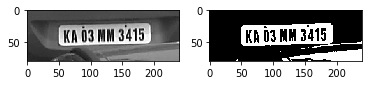

In [135]:
# imagesFolder = os.path.join(mainDir + '/License_Plates_Crop/')
filename = os.path.join(mainDir, 'frame_id_340_1.png')

car_image = imread(filename, as_gray=True)
print(car_image.shape)

gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
# print(binary_car_image)
ax2.imshow(binary_car_image, cmap="gray")
# ax2.imshow(gray_car_image, cmap="gray")
plt.show()

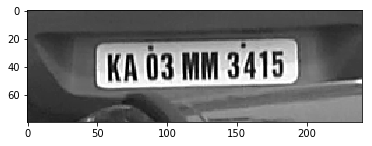

In [136]:
label_image = measure.label(binary_car_image)
# getting the maximum width, height and minimum width and height that a license plate can be
plate_dimensions = (0.03*label_image.shape[0], 0.08*label_image.shape[0], 0.15*label_image.shape[1], 0.3*label_image.shape[1])
plate_dimensions2 = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])

plate_dimensions3 = (0.25*label_image.shape[0], 0.75*label_image.shape[0], 0.20*label_image.shape[1], 0.8*label_image.shape[1])

min_height, max_height, min_width, max_width = plate_dimensions
plate_objects_cordinates = []
plate_like_objects = []

fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray")
flag =0

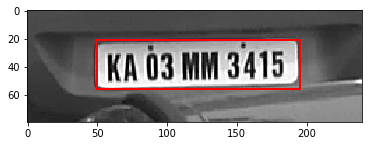

In [137]:
for region in regionprops(label_image):
    # print(region)
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue
        # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    # print(min_row)
    # print(min_col)
    # print(max_row)
    # print(max_col)

    region_height = max_row - min_row
    region_width = max_col - min_col
    # print(region_height)
    # print(region_width)

    # ensuring that the region identified satisfies the condition of a typical license plate
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        flag = 1
        plate_like_objects.append(binary_car_image[min_row:max_row,
                                  min_col:max_col])
        plate_objects_cordinates.append((min_row, min_col,
                                         max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
        # let's draw a red rectangle over those regions
        
if(flag == 1):
    # print(plate_like_objects[0])
    plt.show()
    
if(flag==0):
    min_height, max_height, min_width, max_width = plate_dimensions3
    plate_objects_cordinates = []
    plate_like_objects = []

    fig, (ax1) = plt.subplots(1)
    ax1.imshow(gray_car_image, cmap="gray")

    # regionprops creates a list of properties of all the labelled regions
    for region in regionprops(label_image):
        if region.area < 50:
            #if the region is so small then it's likely not a license plate
            continue
            # the bounding box coordinates
        min_row, min_col, max_row, max_col = region.bbox
        # print(min_row)
        # print(min_col)
        # print(max_row)
        # print(max_col)

        region_height = max_row - min_row
        region_width = max_col - min_col
        # print(region_height)
        # print(region_width)

        # ensuring that the region identified satisfies the condition of a typical license plate
        if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
            # print("hello")
            plate_like_objects.append(binary_car_image[min_row:max_row,
                                      min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col,
                                             max_row, max_col))
            rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                           linewidth=2, fill=False)
            ax1.add_patch(rectBorder)
            # let's draw a red rectangle over those regions
    # print(plate_like_objects[0])
    plt.show()

(35, 145)


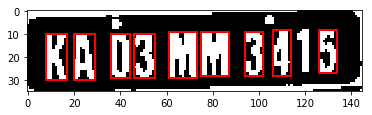

In [138]:
license_plate = np.invert(plate_like_objects[0])

labelled_plate = measure.label(license_plate)

print(license_plate.shape)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

# character_dimensions = (0.25*license_plate.shape[0], 0.85*license_plate.shape[0], 0.04*license_plate.shape[1], 0.12*license_plate.shape[1])
character_dimensions = (0.25*license_plate.shape[0], 0.85*license_plate.shape[0], 0.05*license_plate.shape[1], 0.12*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)
# print(characters)
plt.show()